# Group Members
James Ho, Nicholas Schindler

# Code

In [1]:
##### Imports #####

import csv
import re
from collections import Counter
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA
import seaborn as sns

In [2]:
##### Definitions #####

def load_and_split_csv(filename):
  ham_data = []
  spam_data = []

  with open(filename, newline = '', encoding = 'latin1') as csvfile:
    reader = csv.reader(csvfile)
    next(reader, None)

    for row in reader:
      label, text = row[0].strip().lower(), row[1].strip()
      if 'ham' in label:
        ham_data.append(text)
      elif 'spam' in label:
        spam_data.append(text)

  return ham_data, spam_data

def parse_word_frequencies(text_list):
    word_counter = Counter()

    for text in text_list:
        words = re.findall(r"\b\w+\b", text.lower())
        word_counter.update(words)

    return dict(word_counter)

In [3]:
##### Main #####

# Loads the csv and splits it into a ham dataset and a spam dataset.
ham, spam = load_and_split_csv("spam.csv")

# Get the number of ham and the number of spam messages so we can adjust for frequency.
ham_size = len(ham)
spam_size = len(spam)

# Counts the frequency of each word in ham and spam datasets. The first column is the word, and the second is the count.
# Converts everything to lower case so capitalization does not matter.
ham_parsed = parse_word_frequencies(ham)
spam_parsed = parse_word_frequencies(spam)

# Combine all unique words from both sets
all_words = set(ham_parsed.keys()) | set(spam_parsed.keys())

# Build dataset rows
rows = []
for word in all_words:
    ham_count = ham_parsed.get(word, 0)
    spam_count = spam_parsed.get(word, 0)

    ham_freq = ham_count / ham_size if ham_size > 0 else 0
    spam_freq = spam_count / spam_size if spam_size > 0 else 0

    # A simple spam-likelihood score (higher → more spammy)
    spam_likelihood = (spam_freq + 1e-9) / (ham_freq + spam_freq + 1e-9)

    rows.append([word, ham_count, spam_count, ham_freq, spam_freq, spam_likelihood])

word_dataset = pd.DataFrame(
    rows,
    columns=["word", "ham_count", "spam_count", "ham_freq", "spam_freq", "spam_likelihood"]
)

# Sort by how strongly a word is associated with spam
word_dataset_sorted = word_dataset.sort_values("spam_likelihood", ascending=False)

# Create train and test datasets
word_dataset_sorted['label'] = (word_dataset_sorted['spam_count'] > word_dataset_sorted['ham_count']).astype(int)
feature_cols = ["ham_freq", "spam_freq", "ham_count", "spam_count"]
X = word_dataset_sorted[feature_cols]
y = word_dataset_sorted['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

# Train SVM using grid search for best hyperparameters
pipeline = Pipeline([("scaler", StandardScaler()), ("svm", SVC(probability=True))])

param_grid = {"svm__C": [0.1, 1, 10, 100], "svm__kernel": ["rbf", "poly"], "svm__degree": [2, 3, 4],}

search = GridSearchCV(pipeline, param_grid=param_grid, cv=5, scoring="accuracy", verbose=2, n_jobs=-1)

search.fit(X_train, y_train)
svm_model = search.best_estimator_

Fitting 5 folds for each of 24 candidates, totalling 120 fits


# Good description of the data and methodology



## Dataset
The dataset used in this analysis is the SMS Spam Collection Dataset, a widely used benchmark corpus for spam detection task.

Each corpus contains:
*   A lable indicating whether the message is ham(legitimate message) or spam(scam message)
*   The SMS message itself

This dataset contains over 5,500 messages with ham messages forming the majority of the class. The spam messages typically conatin key marketing phrases, promotional offers, and special numeric patterns.

For this project, the dataset was loaded from a CSV file and split into two set:
*   Ham: all messages labeled "ham", which are real messages
*   Spam: all messages labeled "spam", which are phishing messages


## Data Processing and Feature Construction
This project performs a classification and the word level and not at the message level.

The goal is to determine whether individual words are more predictive of ham or spam content.

### Token and Word Count
For each set, we did:
* Tokenize the messages into individual words after cleaning
* Count the word frequencies separately for ham and spam
* Build a combined vocabulary

This resulted a dataset where each row represented a unique word with features:
* ham_count - how many times the word appears in ham messages
* spam_count - how many times the word appears in spam messages
* ham_freq - normalized frequency within all ham messages
* spam_freq - normalized frequency within all spam messages



## Modeling Methodology
To classify words as ham-learning or spam-learning, we used an SVM classifier. SVM takes into account the fact that the same words are used in both real (ham) and phishing (spam) texts by merit of using a margin.
### Train/Test Split

A standard 80/20 stratified split was used to maintain balanced representation of ham and spam words in both sets.

### Training Pipeline

A scikit-learn pipeline was constructed. We used a grid search to determine hyperparameters. Grid search was selected over random search because this is a relatively small data set, so the time to perform the search is reasonable, and we were curious about how optimized we could make our SVM.

1. StandardScaler
* Standardizes all numeric features
* Necessary for SVM performance

2. SVM with RBF Kernel

* Nonlinear decision boundary

* Well-suited for highly separable features (as in spam detection)

* probability=True enabled probability calibration

The model was trained on the customized features from each word.

# Results are clearly presented and discussed in depth

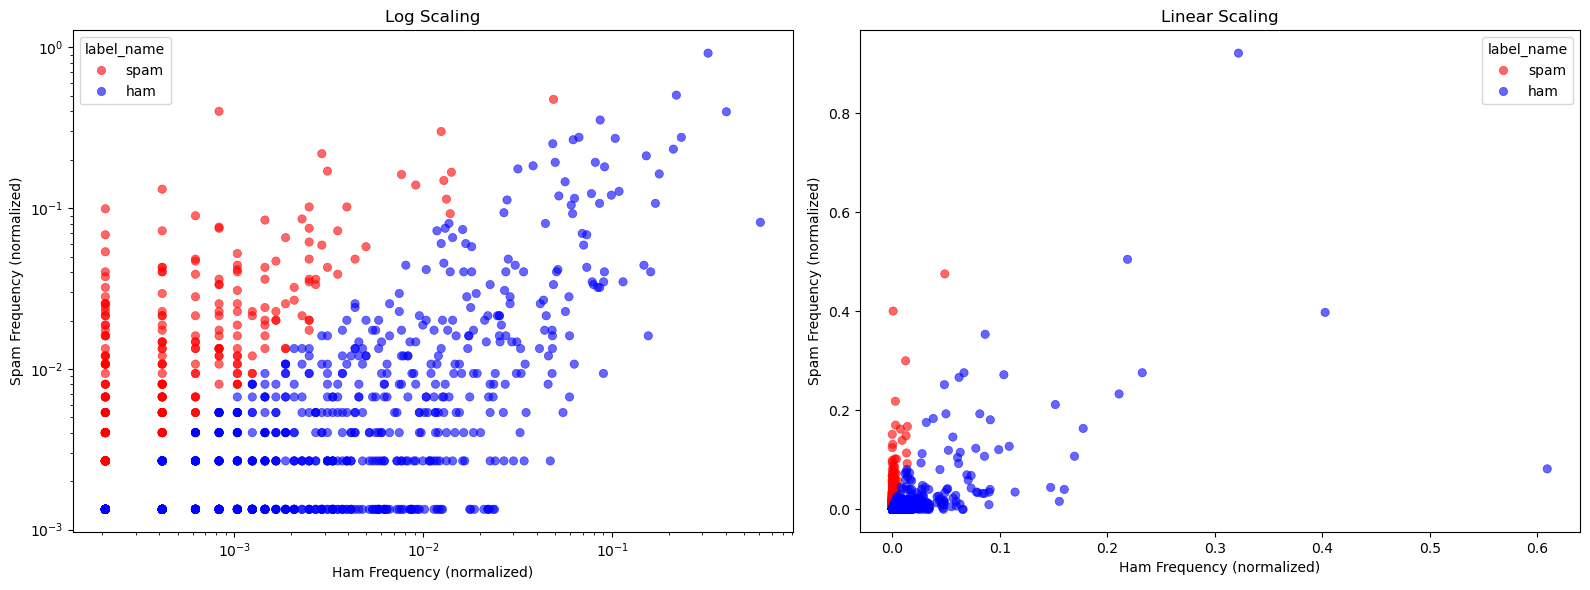

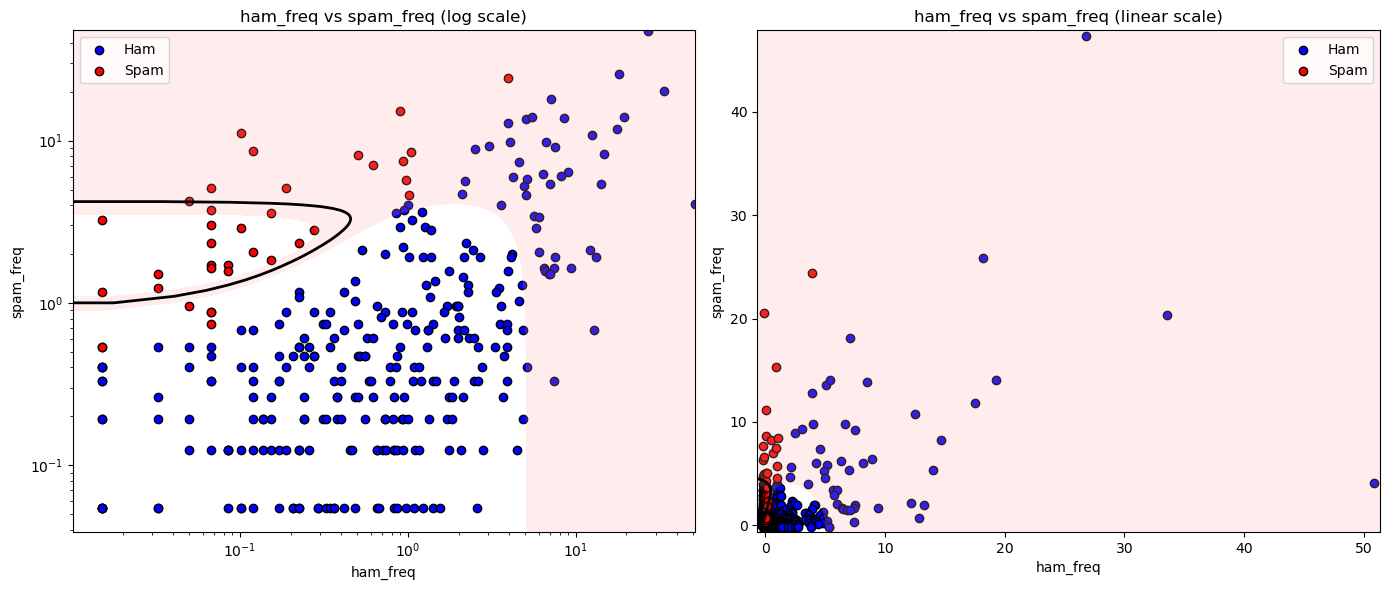


Best hyperparameters: {'svm__C': 100, 'svm__degree': 2, 'svm__kernel': 'rbf'}

SVM Accuracy: 99.828%


In [4]:
word_dataset_sorted["label_name"] = word_dataset_sorted["label"].map({0: "ham", 1: "spam"})

# Create 2 side-by-side plots showing ham vs spam frequency, using both a log scale and linear scale
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
   # log plot
sns.scatterplot(
    data=word_dataset_sorted,
    x="ham_freq",
    y="spam_freq",
    hue="label_name",
    palette={"ham": "blue", "spam": "red"},
    alpha=0.6,
    edgecolor=None,
    ax=axes[0])
axes[0].set_title("Log Scaling")
axes[0].set_xlabel("Ham Frequency (normalized)")
axes[0].set_ylabel("Spam Frequency (normalized)")
axes[0].set_xscale("log")
axes[0].set_yscale("log")
   # not scaled plot
sns.scatterplot(
    data=word_dataset_sorted,
    x="ham_freq",
    y="spam_freq",
    hue="label_name",
    palette={"ham": "blue", "spam": "red"},
    alpha=0.6,
    edgecolor=None,
    ax=axes[1])
axes[1].set_title("Linear Scaling")
axes[1].set_xlabel("Ham Frequency (normalized)")
axes[1].set_ylabel("Spam Frequency (normalized)")
   # show plot
plt.tight_layout()
plt.show()

# Create 2 side-by-side plots showing SVM boundary, using both a log scale and linear scale
epsilon = 1e-3
feat1, feat2 = "ham_freq", "spam_freq"
y_pair = word_dataset_sorted['label'].values
clf = svm_model.named_steps['svm']
feature_index_map = {feat: idx for idx, feat in enumerate(feature_cols)}
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
   # log scale
ax = axes[0]
X_pair = word_dataset_sorted[[feat1, feat2]].values + epsilon
scaler_pair = StandardScaler()
X_pair_scaled = scaler_pair.fit_transform(X_pair)
ax.scatter(X_pair_scaled[y_pair==0, 0], X_pair_scaled[y_pair==0, 1], c='blue', label='Ham', edgecolors='k')
ax.scatter(X_pair_scaled[y_pair==1, 0], X_pair_scaled[y_pair==1, 1], c='red', label='Spam', edgecolors='k')
x_min, x_max = X_pair_scaled[:, 0].min() - 0.5, X_pair_scaled[:, 0].max() + 0.5
y_min, y_max = X_pair_scaled[:, 1].min() - 0.5, X_pair_scaled[:, 1].max() + 0.5
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 500), np.linspace(y_min, y_max, 500))
grid = np.zeros((xx.ravel().shape[0], 4))
grid[:, feature_index_map[feat1]] = xx.ravel()
grid[:, feature_index_map[feat2]] = yy.ravel()
Z = clf.decision_function(grid).reshape(xx.shape)
ax.contour(xx, yy, Z, levels=[0], colors='k', linewidths=2)
ax.contourf(xx, yy, Z, levels=[-1, 1], colors=['#ffa0a0', '#a0c4ff'], alpha=0.2)
ax.set_xlabel(feat1)
ax.set_ylabel(feat2)
ax.set_title(f"{feat1} vs {feat2} (log scale)")
ax.set_xscale('log')
ax.set_yscale('log')
ax.legend()
   # linear scale
ax = axes[1]
X_pair = word_dataset_sorted[[feat1, feat2]].values  # no epsilon
scaler_pair = StandardScaler()
X_pair_scaled = scaler_pair.fit_transform(X_pair)
ax.scatter(X_pair_scaled[y_pair==0, 0], X_pair_scaled[y_pair==0, 1], c='blue', label='Ham', edgecolors='k')
ax.scatter(X_pair_scaled[y_pair==1, 0], X_pair_scaled[y_pair==1, 1], c='red', label='Spam', edgecolors='k')
x_min, x_max = X_pair_scaled[:, 0].min() - 0.5, X_pair_scaled[:, 0].max() + 0.5
y_min, y_max = X_pair_scaled[:, 1].min() - 0.5, X_pair_scaled[:, 1].max() + 0.5
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 500), np.linspace(y_min, y_max, 500))
grid = np.zeros((xx.ravel().shape[0], 4))
grid[:, feature_index_map[feat1]] = xx.ravel()
grid[:, feature_index_map[feat2]] = yy.ravel()
Z = clf.decision_function(grid).reshape(xx.shape)
ax.contour(xx, yy, Z, levels=[0], colors='k', linewidths=2)
ax.contourf(xx, yy, Z, levels=[-1, 1], colors=['#ffa0a0', '#a0c4ff'], alpha=0.2)
ax.set_xlabel(feat1)
ax.set_ylabel(feat2)
ax.set_title(f"{feat1} vs {feat2} (linear scale)")
ax.legend()
plt.tight_layout()
plt.show()

# Print basic data about hyperparameters used and SVM accuracy
print("\nBest hyperparameters:", search.best_params_)
y_pred = svm_model.predict(X_test)
print("\nSVM Accuracy: {:.3f}%".format(accuracy_score(y_test, y_pred) * 100))

As expected based on the type of model we used, there is a linear boundary between ham (real) and spam (phishing) words. This is because the decision boundary is whether a word is used more often in ham or spam messages. You can see this effect most clearly in the top left graph (which is on a log scale), and to a lesser extent on the top right graph (which is the same graph but on a linear scale).

The bottom two graphs are the same as the top two, except they also have the SVM dividing line and the margin. Something interesting that we noticed was how a softer margin (larger C hyperparameter) gives better results. When discussing we concluded that this is a good representation of overlap. Spam messages attempt to mimic real messages, so they use a lot of the same words. This is why all of the most common English words ("the", "a", "day", etc.) are in the margin. Both ham and spam messages are forced to use these words because they're the basic building blocks of scentences.

On the flip side of the coin, there are a small number of words that show up very frequently in spam messages. These are the words inside the peninsula on the bottom left graph. Once again this makes sense - phishing messages are attempting to convince people to click on them, and thus use certain words to imply urgency and request a response. These words are the red flags.

Of note, this algorhithm only classifies individual words, which explains the 99.828% accuracy. We knew going in that the hard part would be preparing the data, and this high accuracy shows that we prepared successfully. The next step would be to take the results of this model and use a voting system to determine the likelihood that a message is ham or spam. A second SVM could analyze the results with metrics like percent of words that are ham, message length, number of misspelled words, etc. We would probably create 10+ variables and use a PCA to determine which are relevant. We chose not to do this because it gets into neural networks.

# Team Member Responsibilities

### Code

James Ho - Process data set into ham and spam likelihoods

Nicholas Schindler - Load and split data set, grid search, SVM

### Report

James Ho - Data and methodology

Nicholas Schindler - Graphs and results analysis